In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20, 10)

## Pull target data

In [2]:
data = yf.download("NVDA", start="2020-03-22", end="2025-03-23", interval="1wk")
data.to_csv("NVDA_historical_wk.csv")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## Convert target data

In [3]:
df_y = pd.read_csv(
    "NVDA_historical_wk.csv",
    skiprows=3,
    index_col='Date',
    names=['Date', 'Close', 'High' , 'Low', 'Open', 'Volume'],
    usecols=['Date', 'Close'],
    dtype={'Close': np.float64},
    parse_dates=True
)
df_y.head()

,Close
Date,
2020-03-23,6.295057
2020-03-30,6.075367
2020-04-06,6.549620
2020-04-13,7.281175
2020-04-20,7.213174


## Convert freature candidates data

In [4]:
def clean_text(value):
    return value.replace('<', '')

df_x = pd.read_csv(
    "multiTimeline.csv",
    skiprows=3,
    index_col='Date',
    names=['Date', 'ai', 'nvidia', 'gpu', 'graphics_card', 'chatgpt'],
    dtype={'ai':str, 'nvidia':str, 'gpu':str, 'graphics_card':str, 'chatgpt':str},
    converters={
        'Date': lambda x: pd.to_datetime(x) + pd.Timedelta(days=1),
        'ai': clean_text, 'nvidia': clean_text, 'gpu': clean_text, 'graphics_card': clean_text, 'chatgpt': clean_text
    },
    parse_dates=True
)

for col in df_x.columns:
    df_x[col] = df_x[col].astype(np.int32)

df_x.head()

/var/folders/w_/rpxbwhbn36d2dr6vcwrxgqfw0000gp/T/ipykernel_92763/2661636692.py:4: ParserWarning: Both a converter and dtype were specified for column ai - only the converter will be used.
  df_x = pd.read_csv(
/var/folders/w_/rpxbwhbn36d2dr6vcwrxgqfw0000gp/T/ipykernel_92763/2661636692.py:4: ParserWarning: Both a converter and dtype were specified for column nvidia - only the converter will be used.
  df_x = pd.read_csv(
/var/folders/w_/rpxbwhbn36d2dr6vcwrxgqfw0000gp/T/ipykernel_92763/2661636692.py:4: ParserWarning: Both a converter and dtype were specified for column gpu - only the converter will be used.
  df_x = pd.read_csv(
/var/folders/w_/rpxbwhbn36d2dr6vcwrxgqfw0000gp/T/ipykernel_92763/2661636692.py:4: ParserWarning: Both a converter and dtype were specified for column graphics_card - only the converter will be used.
  df_x = pd.read_csv(
/var/folders/w_/rpxbwhbn36d2dr6vcwrxgqfw0000gp/T/ipykernel_92763/2661636692.py:4: ParserWarning: Both a converter and dtype were specified for c

,ai,nvidia,gpu,graphics_card,chatgpt
Date,,,,,
2020-03-23,3,0,1,2,0
2020-03-30,3,0,1,2,0
2020-04-06,3,0,1,2,0
2020-04-13,3,0,1,2,0
2020-04-20,3,0,1,2,0


## Align dates

In [5]:
print(f'X length: {df_x.shape[0]}, Y length: {df_y.shape[0]}')
df_y = df_y.loc[df_y.index.intersection(df_x.index)]
df_x = df_x.loc[df_x.index.intersection(df_y.index)]
print(f'X length: {df_x.shape[0]}, Y length: {df_y.shape[0]}')

X length: 262, Y length: 261
X length: 261, Y length: 261


## Plot feature candidates and target

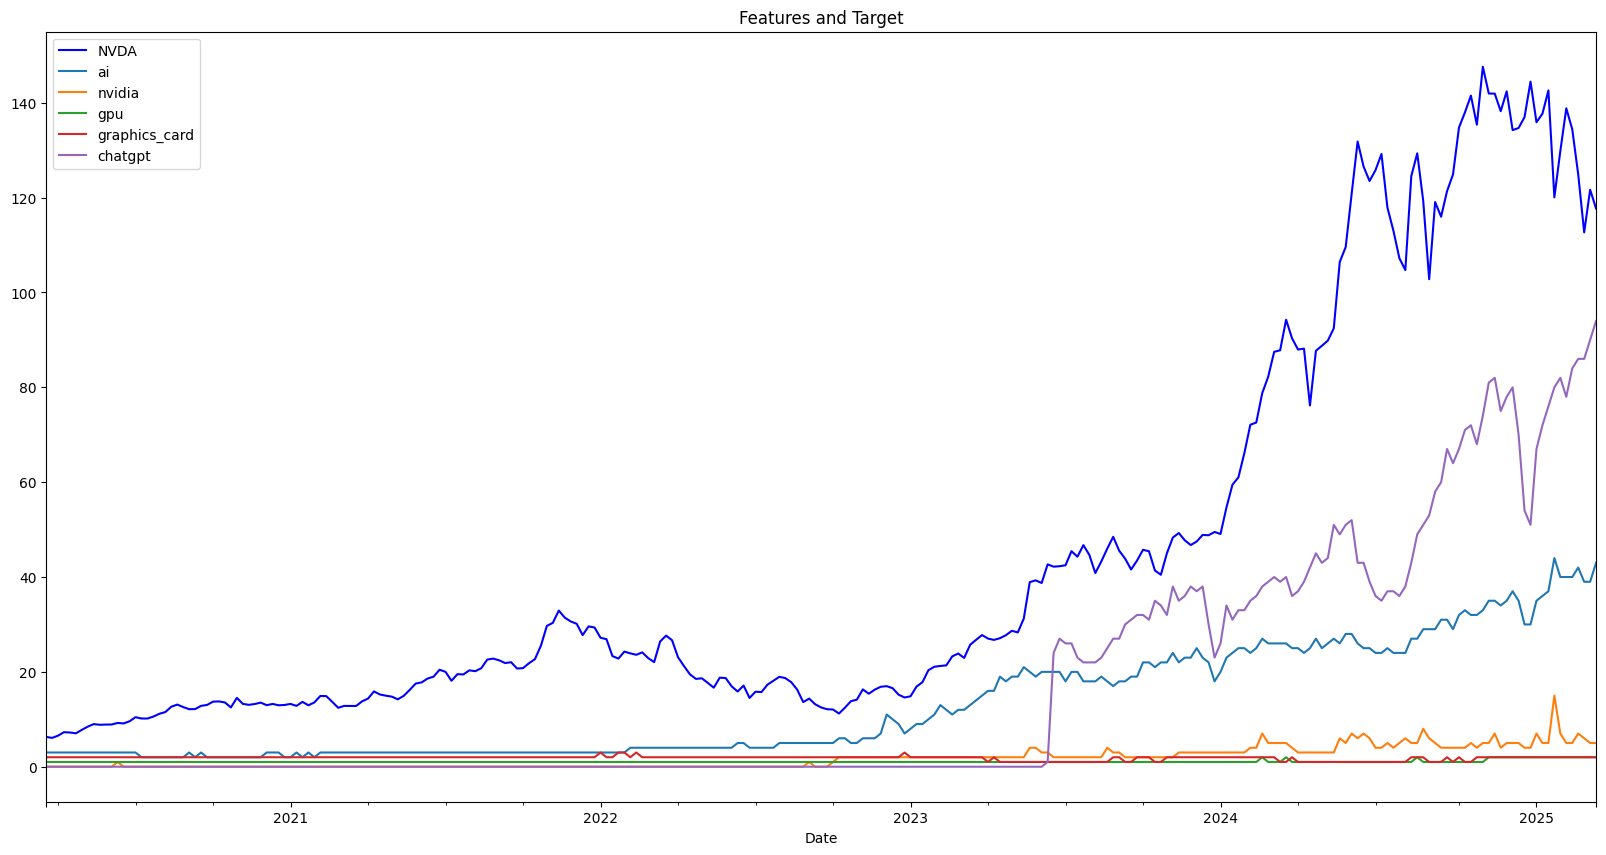

In [6]:
fig, ax = plt.subplots()
ax.set_title('Features and Target');
df_y['Close'].plot(ax=ax, label='NVDA', color='blue');
for col in df_x.columns:
    df_x[col].plot(ax=ax, label=col);
ax.legend();

## Correlation matrix

In [7]:
pd.concat([df_x, df_y], axis=1).corr()

,ai,nvidia,gpu,graphics_card,chatgpt,Close
ai,1.000000,0.909162,0.596282,-0.435944,0.940226,0.911795
nvidia,0.909162,1.000000,0.554983,-0.390327,0.841780,0.858391
gpu,0.596282,0.554983,1.000000,0.092635,0.665716,0.612103
graphics_card,-0.435944,-0.390327,0.092635,1.000000,-0.302322,-0.372247
chatgpt,0.940226,0.841780,0.665716,-0.302322,1.000000,0.939818
Close,0.911795,0.858391,0.612103,-0.372247,0.939818,1.000000


## Useful functions

In [8]:
def train_test_split(perc, features=['chatgpt']):
    train_size = int(df_x.shape[0] * perc)
    X_train = df_x[features].iloc[:train_size].to_numpy()
    Y_train = df_y['Close'].iloc[:train_size].to_numpy().reshape(-1,1)
    X_test = df_x[features].iloc[train_size:].to_numpy()
    Y_test = df_y['Close'].iloc[train_size:].to_numpy().reshape(-1,1)
    return X_train, X_test, Y_train, Y_test

In [9]:
def train(X_train, Y_train):
    return np.linalg.solve(X_train.T.dot(X_train), X_train.T.dot(Y_train)) # weights

In [10]:
def r_squared(y, y_hat):
    d1 = y - y_hat
    d2 = y - y.mean()
    SS_res = d1.T.dot(d1)
    SS_tot = d2.T.dot(d2)
    return (1 - SS_res / SS_tot).item()

In [11]:
def test(X_test, w, Y_test):
    Y_test_hat = X_test.dot(w)
    return r_squared(Y_test, Y_test_hat)

In [12]:
def validation_loop(hyperparams):
    r2s = []
    for params in hyperparams:
        X_train, X_test, Y_train, Y_test = train_test_split(perc=params['split'],features=params['features'])
        weights = train(X_train, Y_train)
        r2 = test(X_test, weights, Y_test)
        r2s.append(r2)
    return r2s

## Hyperparameters - 1st shot

In [13]:
hyper = [
    {'split':0.7, 'features':['chatgpt']},
    {'split':0.7, 'features':['chatgpt', 'ai' ]},
    {'split':0.7, 'features':['chatgpt', 'ai', 'nvidia']},
    {'split':0.7, 'features':['chatgpt', 'ai', 'nvidia', 'gpu']},
    {'split':0.7, 'features':['chatgpt', 'ai', 'nvidia', 'gpu', 'graphics_card']},
    {'split':0.75, 'features':['chatgpt']},
    {'split':0.75, 'features':['chatgpt', 'ai' ]},
    {'split':0.75, 'features':['chatgpt', 'ai', 'nvidia']},
    {'split':0.75, 'features':['chatgpt', 'ai', 'nvidia', 'gpu']},
    {'split':0.75, 'features':['chatgpt', 'ai', 'nvidia', 'gpu', 'graphics_card']},
    {'split':0.8, 'features':['chatgpt']},
    {'split':0.8, 'features':['chatgpt', 'ai' ]},
    {'split':0.8, 'features':['chatgpt', 'ai', 'nvidia']},
    {'split':0.8, 'features':['chatgpt', 'ai', 'nvidia', 'gpu']},
    {'split':0.8, 'features':['chatgpt', 'ai', 'nvidia', 'gpu', 'graphics_card']},
    {'split':0.85, 'features':['chatgpt']},
    {'split':0.85, 'features':['chatgpt', 'ai' ]},
    {'split':0.85, 'features':['chatgpt', 'ai', 'nvidia']},
    {'split':0.85, 'features':['chatgpt', 'ai', 'nvidia', 'gpu']},
    {'split':0.85, 'features':['chatgpt', 'ai', 'nvidia', 'gpu', 'graphics_card']},
    {'split':0.9, 'features':['chatgpt']},
    {'split':0.9, 'features':['chatgpt', 'ai' ]},
    {'split':0.9, 'features':['chatgpt', 'ai', 'nvidia']},
    {'split':0.9, 'features':['chatgpt', 'ai', 'nvidia', 'gpu']},
    {'split':0.9, 'features':['chatgpt', 'ai', 'nvidia', 'gpu', 'graphics_card']},
]
r2s = validation_loop(hyper)

## R-squarred - 1st shot

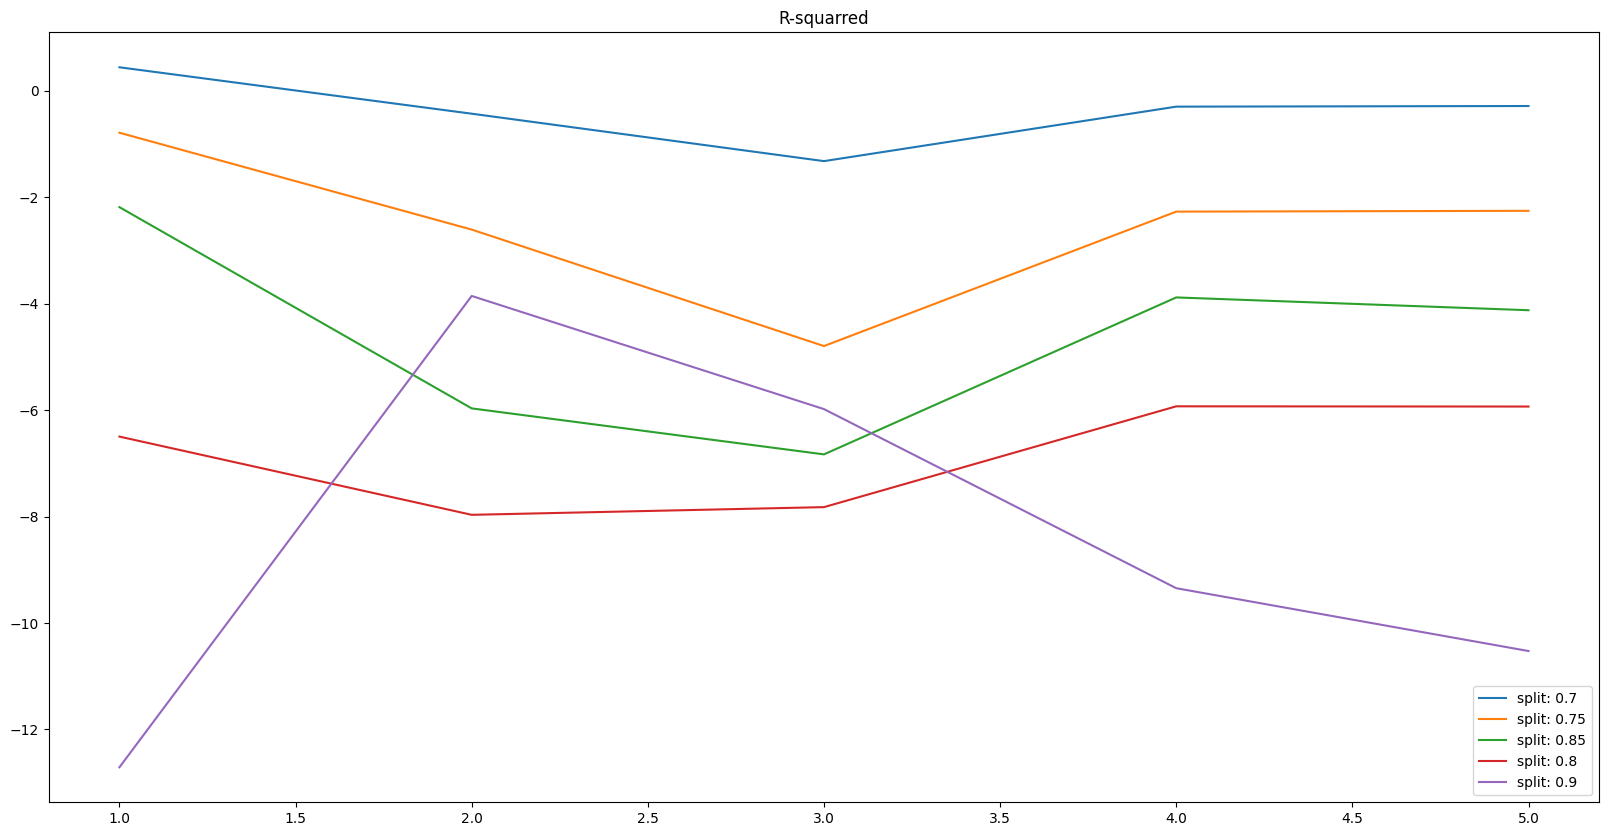

In [14]:
chunks = np.array_split(r2s, len(r2s)/5)
x = np.linspace(1, 5, 5)
for label, chunk in zip(list(set([z['split'] for z in hyper])), chunks):
    plt.plot(x, chunk, label=f'split: {label}');
plt.legend();
plt.title('R-squarred');

## Additional metrics

In [15]:
def mae(y, y_pred):
    return np.mean(np.abs(y - y_pred))

def mse(y, y_pred):
    return np.mean((y - y_pred) ** 2)

def rmse(y, y_pred):
    return np.sqrt(np.mean((y - y_pred) ** 2))

def mape(y, y_pred):
    return np.mean(np.abs((y - y_pred) / y)) * 100

## Generate dense hyperparametrs for promising hyperparameters segment

In [16]:
features = ['chatgpt', 'ai', 'nvidia', 'gpu', 'graphics_card']
hyper_params = []
for split in np.linspace(0.65, 0.95, 100).tolist():
    for f in range(len(features)):
        hyper_params.append(
            dict(
                split=split,
                features=features[:f+1]
            )
        )
hyper_params[:10]

[{'split': 0.65, 'features': ['chatgpt']},
 {'split': 0.65, 'features': ['chatgpt', 'ai']},
 {'split': 0.65, 'features': ['chatgpt', 'ai', 'nvidia']},
 {'split': 0.65, 'features': ['chatgpt', 'ai', 'nvidia', 'gpu']},
 {'split': 0.65,
  'features': ['chatgpt', 'ai', 'nvidia', 'gpu', 'graphics_card']},
 {'split': 0.6530303030303031, 'features': ['chatgpt']},
 {'split': 0.6530303030303031, 'features': ['chatgpt', 'ai']},
 {'split': 0.6530303030303031, 'features': ['chatgpt', 'ai', 'nvidia']},
 {'split': 0.6530303030303031, 'features': ['chatgpt', 'ai', 'nvidia', 'gpu']},
 {'split': 0.6530303030303031,
  'features': ['chatgpt', 'ai', 'nvidia', 'gpu', 'graphics_card']}]

## Final training/tuning

In [17]:
val_weights = []
def validation_loop_2(hyperparams):
    r2s = []
    maes = []
    mses = []
    rmses = []
    mapes = []
    for params in hyperparams:
        X_train, X_test, Y_train, Y_test = train_test_split(perc=params['split'],features=params['features'])
        weights = train(X_train, Y_train)
        val_weights.append(weights)
        r2 = test(X_test, weights, Y_test)
        r2s.append(r2)
        maes.append(mae(Y_test, X_test.dot(weights)))
        mses.append(mse(Y_test, X_test.dot(weights)))
        rmses.append(rmse(Y_test, X_test.dot(weights)))
        mapes.append(mape(Y_test, X_test.dot(weights)))
    return r2s, maes, mses, rmses, mapes

## Plot final metrics 

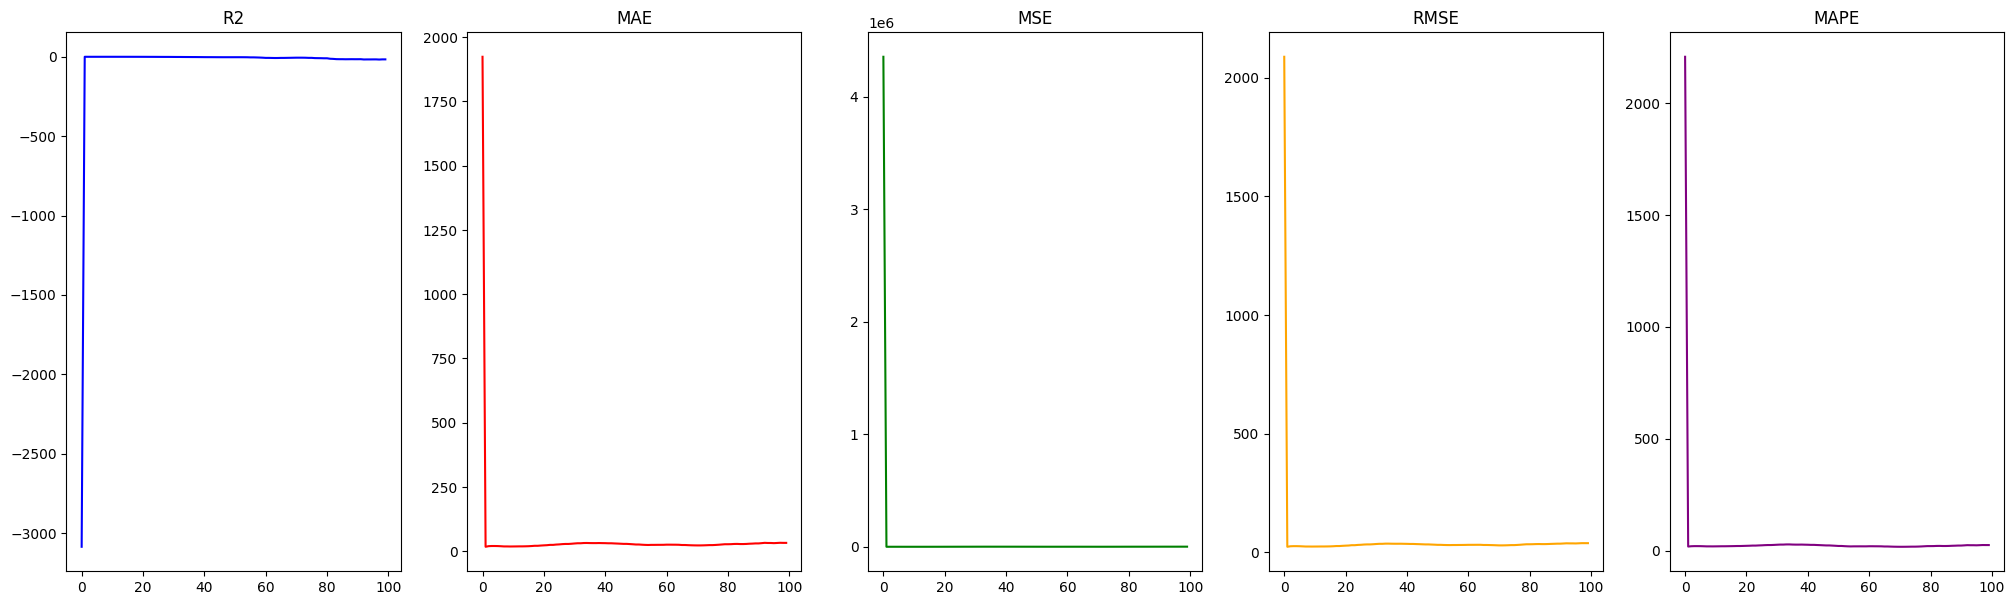

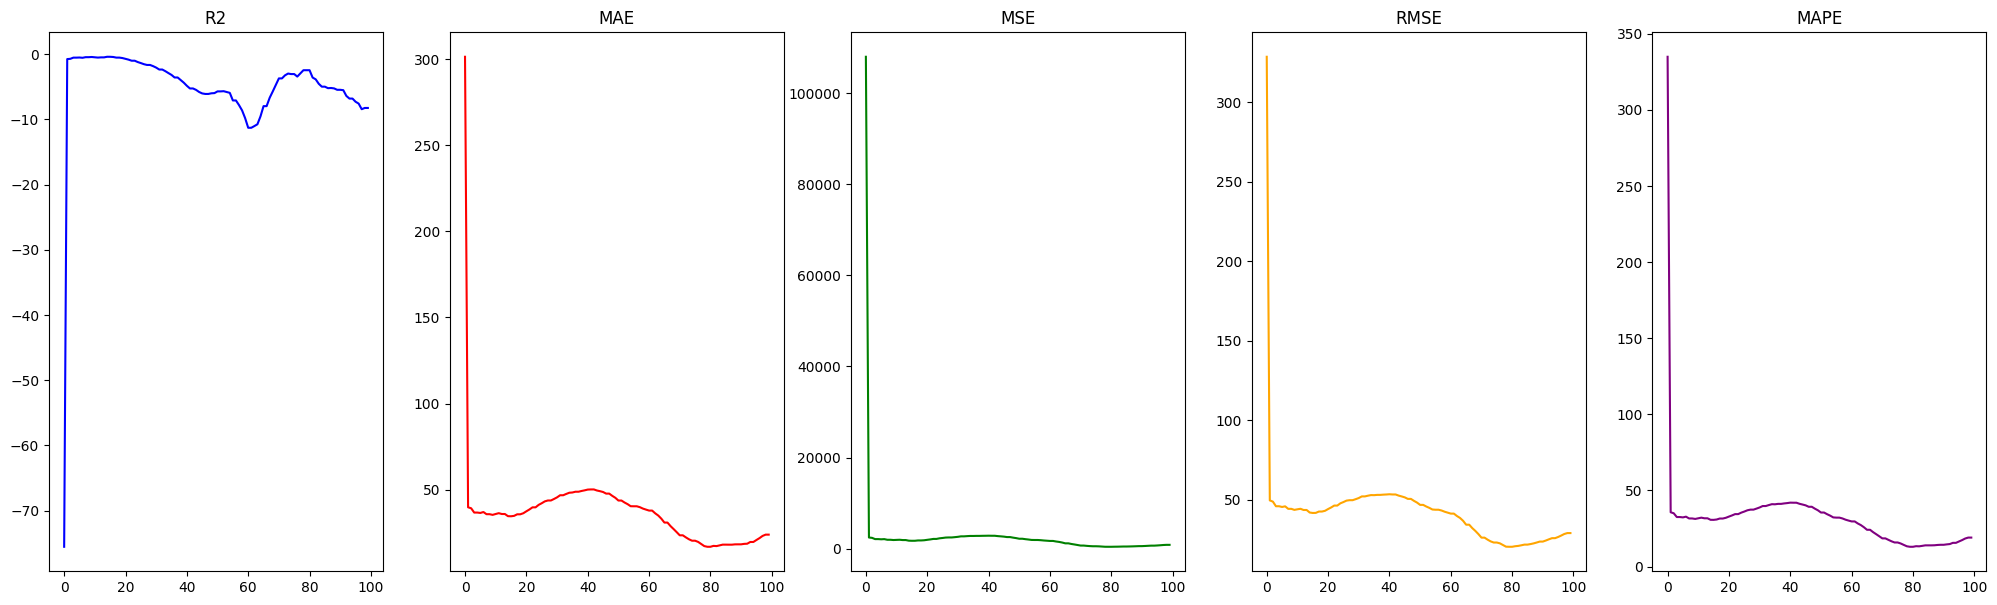

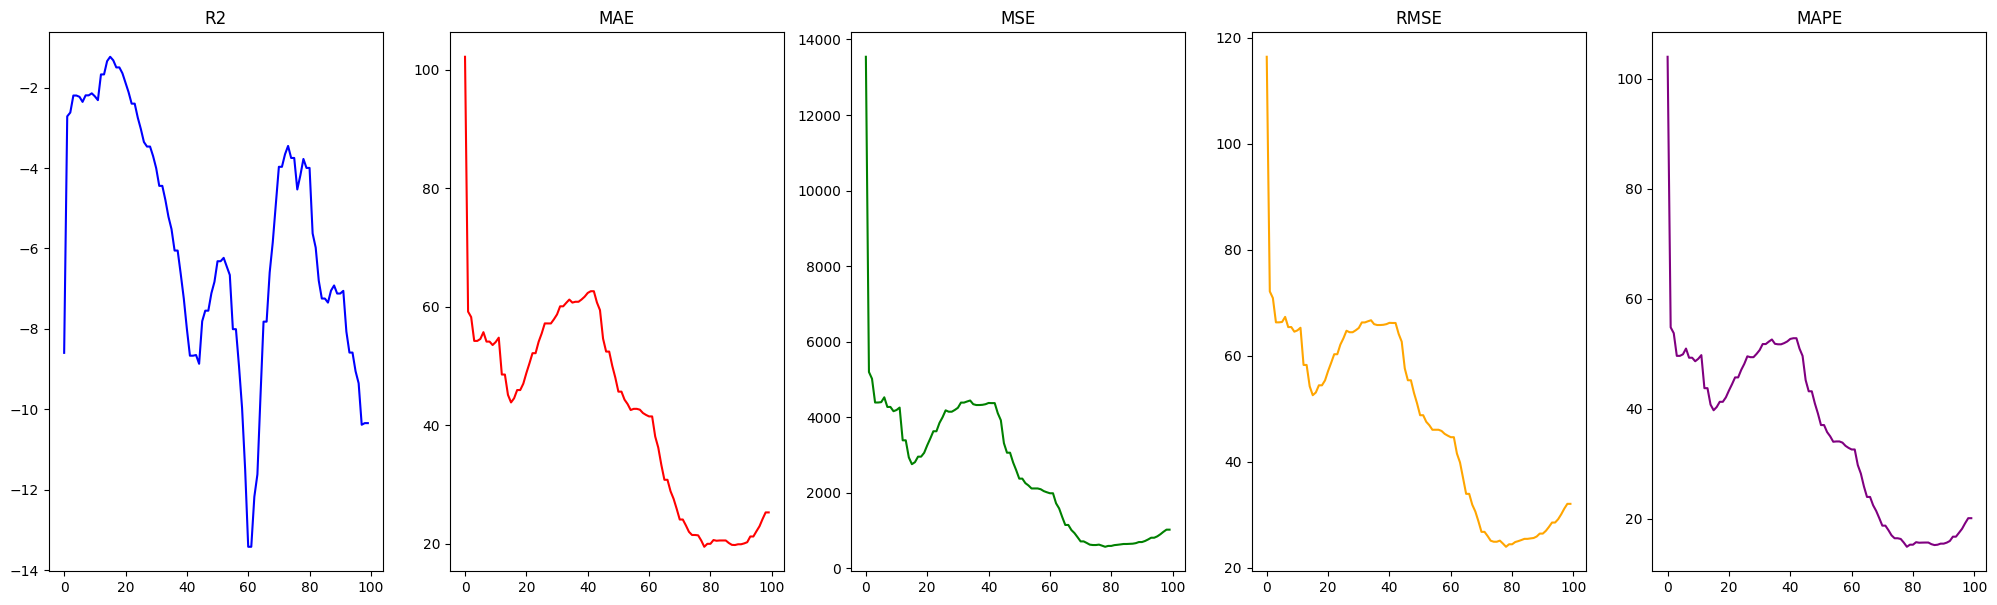

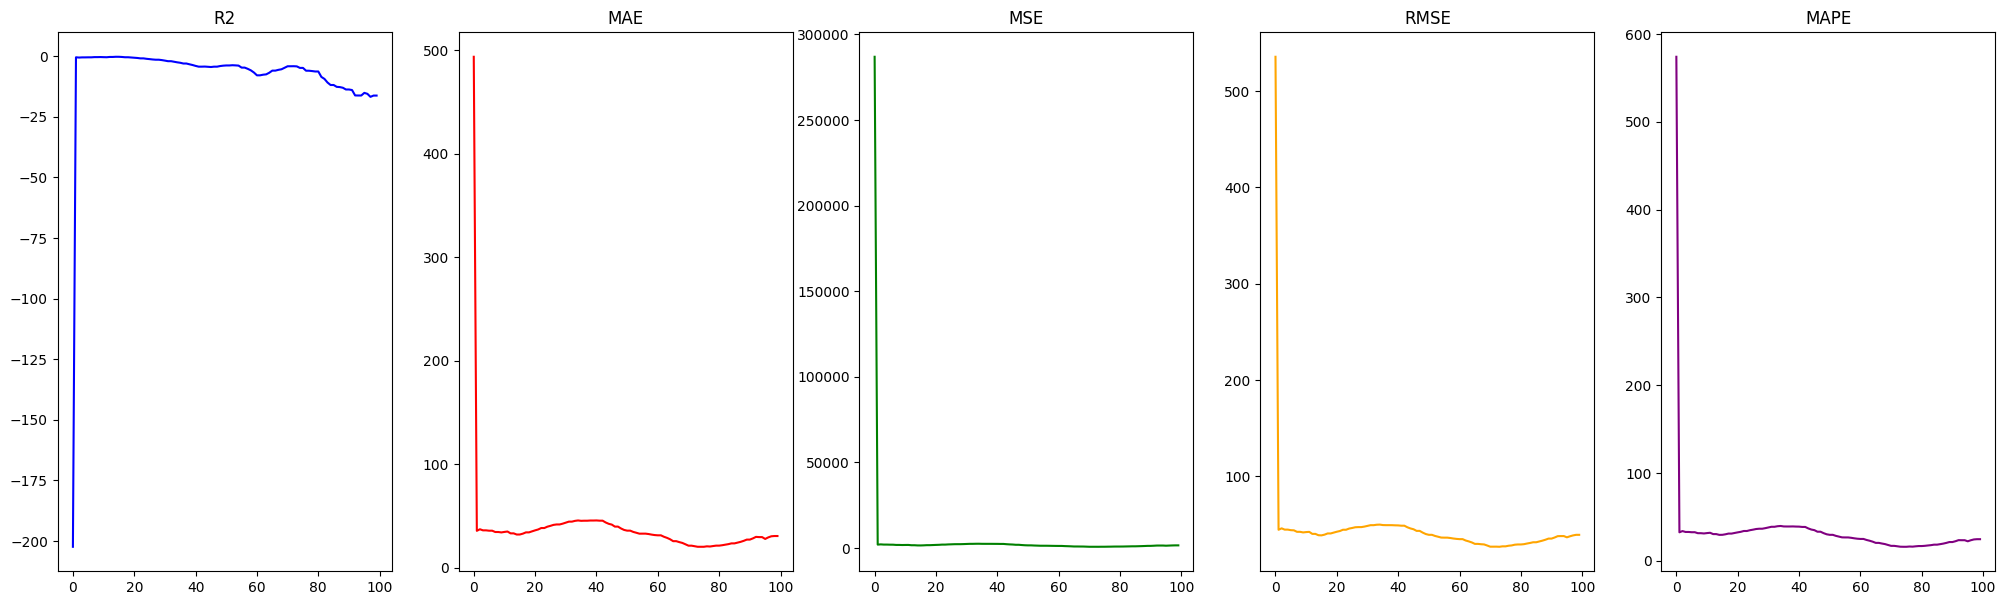

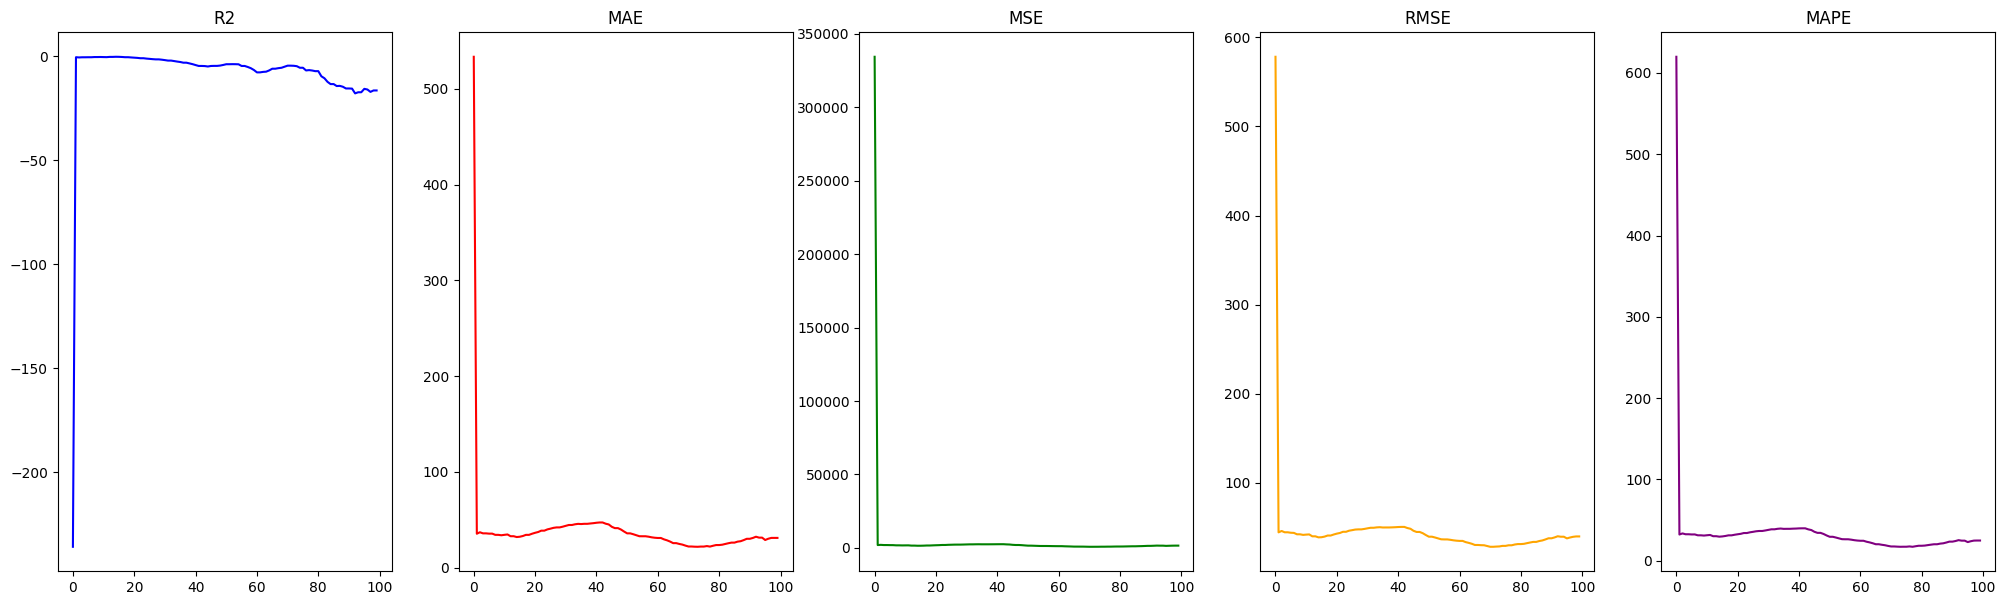

In [18]:
metrics = validation_loop_2(hyper_params)
for feat in range(5):
    fig, axes = plt.subplots(1, 5, figsize=(25, 7))
    for i, label, color in zip(range(5), ['r2', 'mae', 'mse', 'rmse', 'mape'], ['b', 'r', 'g', 'orange','purple']):
        axes[i].plot(metrics[i][feat::5], label=label, color=color)
        axes[i].set_title(label.upper())

## Final results

Top-5 R-squarred values:[0.5987282471237974, 0.5417298255430103, 0.5408817899899079, 0.5408817899899079, 0.5306082516708199]

Best hyperparameter:{'split': 0.6530303030303031, 'features': ['chatgpt']}



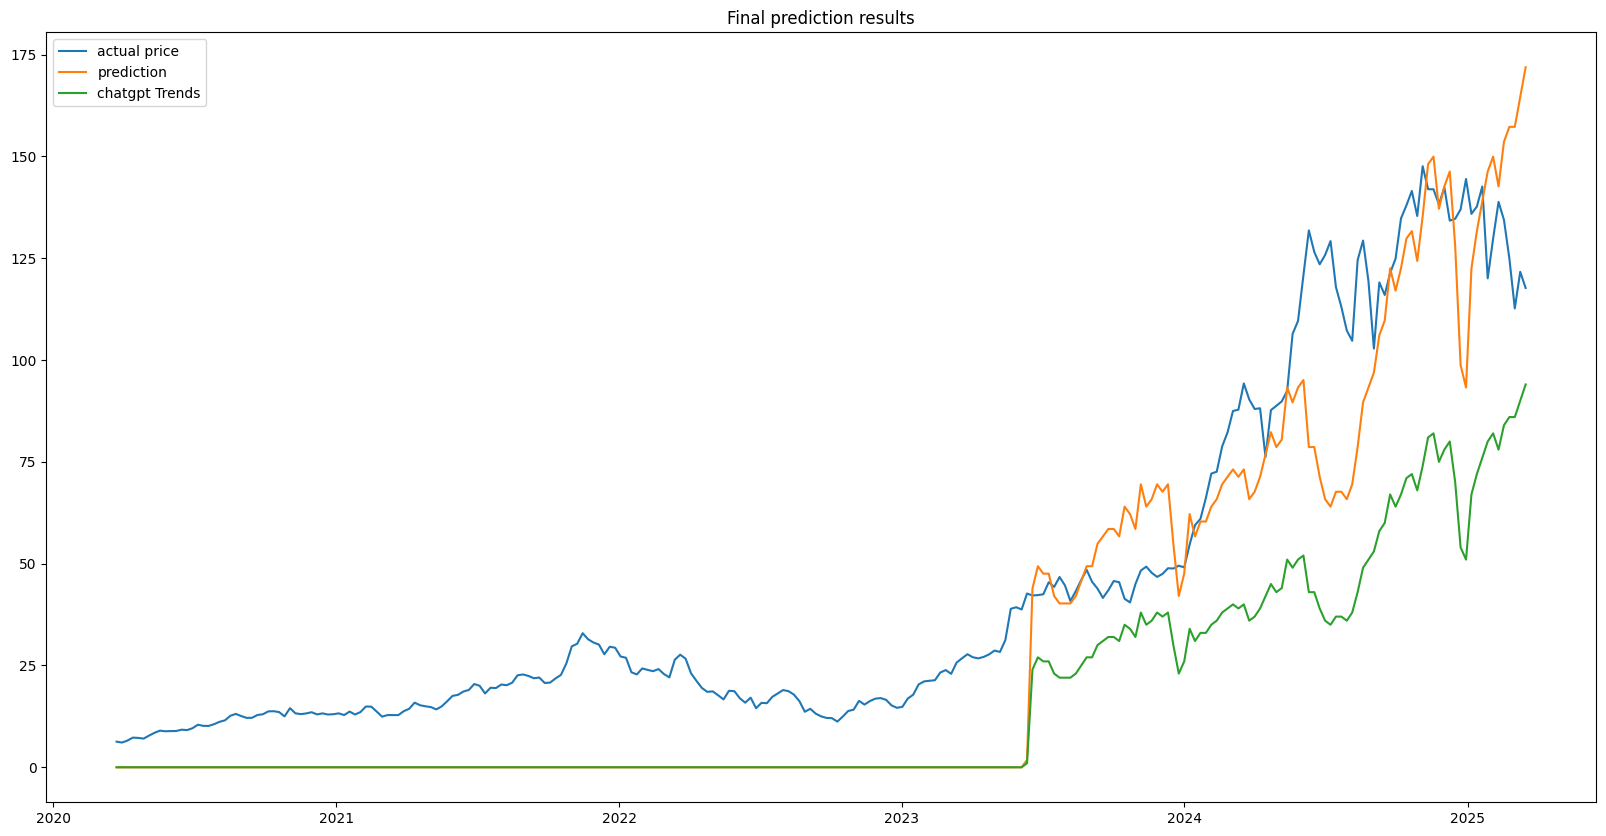

In [21]:
r2s_smallest = np.argsort(metrics[0])[-5:][::-1]
print(f'Top-5 R-squarred values:{[metrics[0][i] for i in r2s_smallest]}')
print()
print(f'Best hyperparameter:{hyper_params[r2s_smallest[0]]}')
print()
val_pred = df_x[hyper_params[r2s_smallest[0]]['features']].dot(val_weights[r2s_smallest[0]])
plt.plot(df_y, label='actual price');
plt.plot(val_pred, label='prediction');
plt.plot(df_x[hyper_params[r2s_smallest[0]]['features']], label='chatgpt Trends');
plt.legend();
plt.title('Final prediction results');